In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

from fastai.vision.all import *

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, num_workers=4)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [4]:
class ConVAE(nn.Module):
    def __init__(self):
        super(ConVAE,self).__init__()

        self.bottleneck_neurons = 20

        self.encoder = nn.Sequential(                                       #28
                nn.Conv2d(1, 32, kernel_size= 3, stride= 2, padding  = 1),  #14
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size= 3, stride= 2, padding  = 1),  #7
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Flatten(),
                nn.Linear(3136, 64),
                nn.ReLU()
        )

        self.decoder = nn.Sequential(                                       
                nn.Linear(self.bottleneck_neurons, 64),
                nn.ReLU(),
                nn.Linear(64, 3136),
                nn.ReLU(),
                nn.Unflatten(1, (64, 7, 7)),    #7
                nn.ConvTranspose2d(64, 32, kernel_size=3, stride= 2, padding  = 1, output_padding=1),   #14
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 1, kernel_size=3, stride= 2, padding  = 1, output_padding=1),  #28
                nn.Sigmoid()
        )

        self.fc1_mu = nn.Linear(64, self.bottleneck_neurons)
        self.fc2_logvar = nn.Linear(64, self.bottleneck_neurons)


    def encode(self, x):
        h = self.encoder(x)
        return self.fc1_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [53]:
model = ConVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

Introducing schedullers

In [7]:
num_batches = len(dataloader)
print(num_batches)

938


In [54]:
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

steps = len(dataloader)
num_epochs = 30

sched = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps, epochs=num_epochs)

Applying HE weight initilization 

In [55]:
from torch.nn import init

def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.ConvTranspose2d)): init.kaiming_normal_(m.weight)
    
model.apply(init_weights)

ConVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=64, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3136, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), outpu

We can check model layers statistics :

In [ ]:
for name, module in model.named_modules():
    if hasattr(module, 'weight') and module.weight is not None:
        weight_mean = module.weight.data.mean().item()
        weight_std = module.weight.data.std().item()
        print(f"Layer: {name} | Weight Mean: {weight_mean:.4f} | Weight Std: {weight_std:.4f}")
    if hasattr(module, 'bias') and module.bias is not None:
        bias_mean = module.bias.data.mean().item()
        bias_std = module.bias.data.std().item()
        print(f"Layer: {name} | Bias Mean: {bias_mean:.4f} | Bias Std: {bias_std:.4f}")

In [56]:
# Variables to store statistics
train_rc_losses = []
train_kl_losses = []
train_loss = []

# Start training
for epoch in range(num_epochs):
    kl_avg = []
    for i, (x, _) in enumerate(dataloader):
        # Forward pass
        # x = x.to(device).view(-1, 784)
        x = x.to(device)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_rc_losses.append(reconst_loss.item())
        train_kl_losses.append(kl_div.item())
        train_loss.append(loss.item())
        kl_avg.append(kl_div.item())
        # Step the scheduler
        sched.step()

    print ("Epoch[{}/{}], Reconst Loss: {:.4f}, epoch avg KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, reconst_loss.item(), sum(kl_avg)/len(kl_avg)))

    # Print current learning rate
    current_lr = sched.get_last_lr()[0]
    # print(f"Epoch {epoch + 1}, Learning Rate: {current_lr:.6f}")

Epoch[1/30], Reconst Loss: -509424.0312, epoch avg KL Div: 3213.8465
Epoch[2/30], Reconst Loss: -679934.5625, epoch avg KL Div: 4118.6022
Epoch[3/30], Reconst Loss: -762460.7500, epoch avg KL Div: 4228.4429
Epoch[4/30], Reconst Loss: -837957.0625, epoch avg KL Div: 4166.1850
Epoch[5/30], Reconst Loss: -899264.6875, epoch avg KL Div: 4153.0176
Epoch[6/30], Reconst Loss: -969290.7500, epoch avg KL Div: 4248.3029
Epoch[7/30], Reconst Loss: -1011964.0000, epoch avg KL Div: 4300.9224
Epoch[8/30], Reconst Loss: -1057413.7500, epoch avg KL Div: 4383.5215
Epoch[9/30], Reconst Loss: -1091382.2500, epoch avg KL Div: 4409.5746
Epoch[10/30], Reconst Loss: -1097542.0000, epoch avg KL Div: 4414.8326
Epoch[11/30], Reconst Loss: -1103784.5000, epoch avg KL Div: 4495.1980
Epoch[12/30], Reconst Loss: -1116435.2500, epoch avg KL Div: 4432.8629
Epoch[13/30], Reconst Loss: -1125497.7500, epoch avg KL Div: 4430.7644
Epoch[14/30], Reconst Loss: -1130538.0000, epoch avg KL Div: 4467.1807
Epoch[15/30], Reconst

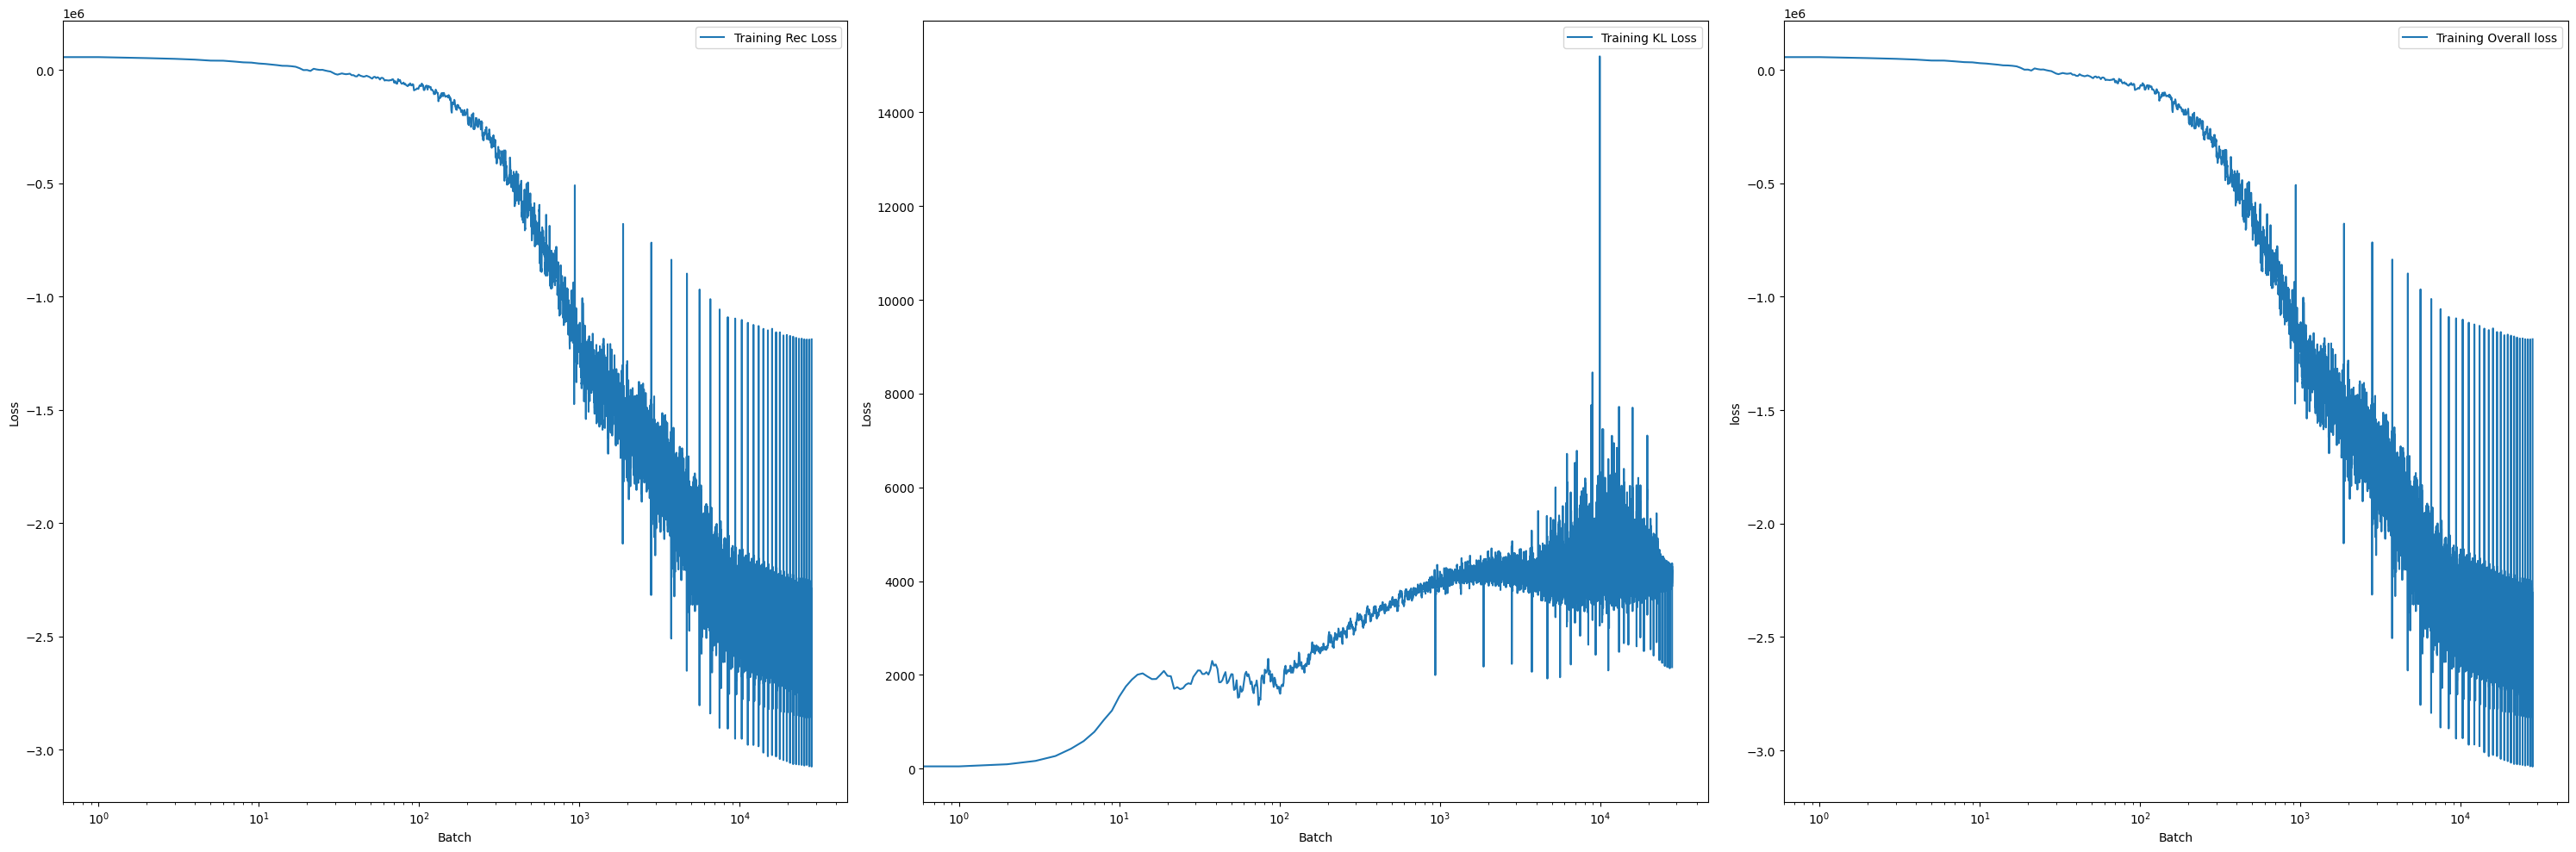

In [57]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10)) 

axs[0].plot(train_rc_losses, label='Training Rec Loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[0].set_xscale('log')
axs[0].legend()


axs[1].plot(train_kl_losses, label='Training KL Loss')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[1].set_xscale('log')
axs[1].legend()

axs[2].plot(train_loss, label='Training Overall loss')
axs[2].set_xlabel('Batch')
axs[2].set_ylabel('loss')
axs[2].set_xscale('log')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [35]:
with torch.no_grad():
    z = torch.randn(32, 20).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)

    out2, _, _ = model(x)
    out2 = out2.view(-1, 1, 28, 28)

    out3 = x.view(-1, 1, 28, 28)

In [48]:
def print_stats(tensor):
    print("Mean:", tensor.mean().item())
    print("Standard Deviation:", tensor.std().item())
    print("Min:", tensor.min().item())
    print("Max:", tensor.max().item())
    print("Median:", tensor.median().item())
    print("Sum:", tensor.sum().item())

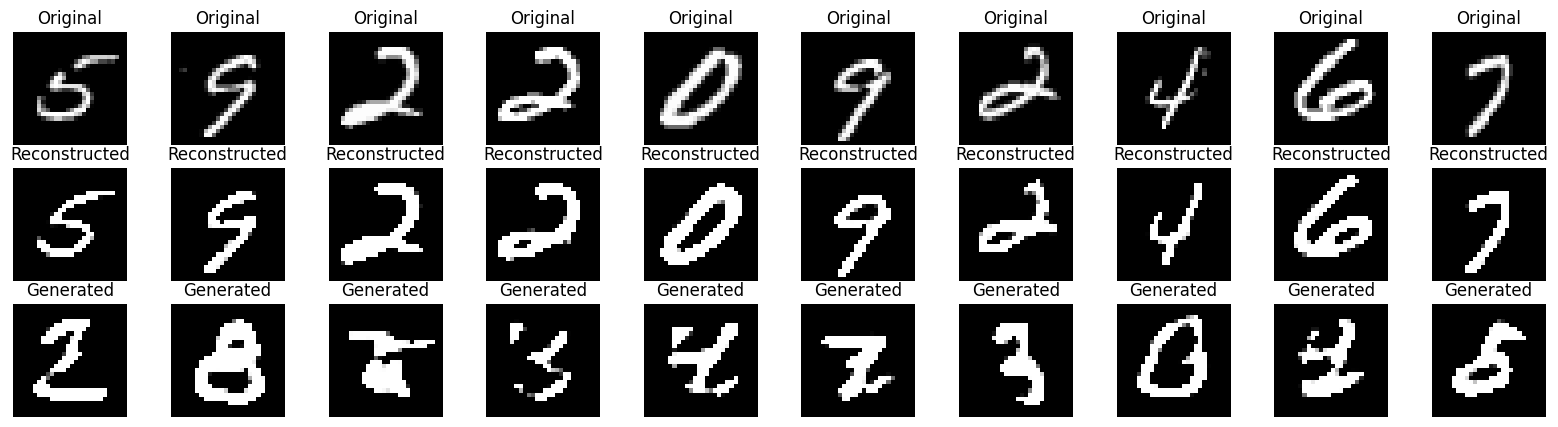

In [36]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

num_images = 10
fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2, 5))
for i in range(num_images):

    # inputs
    axes[0, i].imshow(out3[i].squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    # outputs
    axes[1, i].imshow(out2[i].squeeze().cpu().numpy(), cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

    # rand sample
    axes[2, i].imshow(out[i].squeeze().cpu().numpy(), cmap='gray')
    axes[2, i].set_title('Generated')
    axes[2, i].axis('off')

In [58]:
from torchvision.utils import save_image

# Define the directory and file path
output_dir = '/home/ilua/FastAi_part2/lecture15/results/'
output_file = 'sample_pic.png'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    sample = model.decode(sample).cpu()
    # print_stats(sample)
    save_image(sample.view(64, 1, 28, 28), os.path.join(output_dir, output_file))

Let's do some latent interpolations between two input digits

In [59]:
def interpolate_and_plot(vae, img1, img2, steps=10):
    # Encode the two images
    mu1, log_var1 = vae.encode(img1)
    z1 = vae.reparameterize(mu1, log_var1)

    mu2, log_var2 = vae.encode(img2)
    z2 = vae.reparameterize(mu2, log_var2)

    # Interpolate between z1 and z2
    interpolated_images = []
    for alpha in torch.linspace(0, 1, steps):
        z = (1 - alpha) * z1 + alpha * z2
        img_recon = vae.decode(z)
        interpolated_images.append(img_recon.detach().cpu().numpy().reshape(28, 28))  # Assuming 28x28 image size

    # Plotting
    fig, axs = plt.subplots(1, steps, figsize=(steps * 2, 2))
    for i, img in enumerate(interpolated_images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()

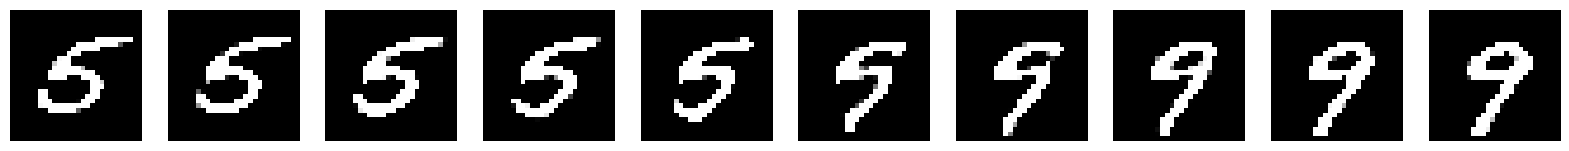

In [60]:
image1 = x.cpu()[0]
image2 = x.cpu()[5]
modelcpu = model.to('cpu')

interpolate_and_plot(model, image1.unsqueeze(1), image2.unsqueeze(1))

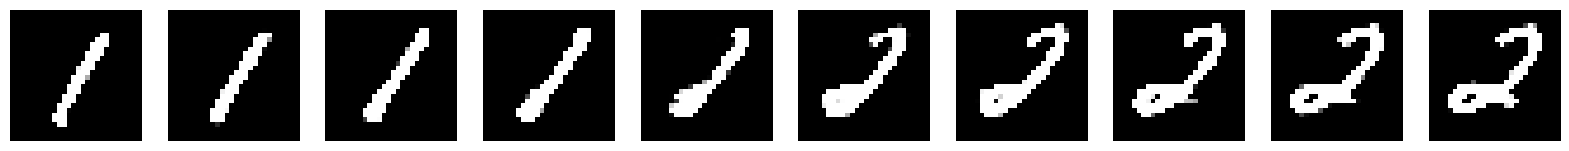

In [61]:
image1 = x.cpu()[11]
image2 = x.cpu()[23]
modelcpu = model.to('cpu')

interpolate_and_plot(model, image1.unsqueeze(1), image2.unsqueeze(1))